# Kodowanie obrazów za pomocą "programów" w Gimpie

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from src.coding.coding import RandomEncoder, RandomDecoder
import random
import os

IMAGES_PATH = '../data/image/scaled_images/'

def random_img():
    return random.choice(os.listdir(IMAGES_PATH))

def show_img(img_path):
    image_data = plt.imread(os.path.join(IMAGES_PATH, img_path))[:,:,:3]
    plt.imshow(image_data)

Using TensorFlow backend.


In [2]:
encoder = RandomEncoder()
decoder = RandomDecoder()

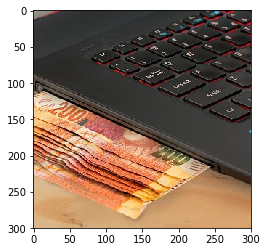

In [3]:
img_path = random_img()
show_img(img_path)

In [9]:
encoded, _ = encoder.encode(img_path, actions=200, size=300, render=True, to_bytes=True)

compressed to action vector of 8844 bytes
compressed with AC to 8131 bytes
compressed in 84.68446803092957 sec


In [5]:
print(encoded[0:100])

b'\x00\x00\x00R\x00\x00\x00\x03\x00\x00\x00\x03\x00\x00\x00\x02\x00\x00\x00\x02\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01'


decompressed from AC to 8844 bytes
decompressed in 5.781483888626099 sec


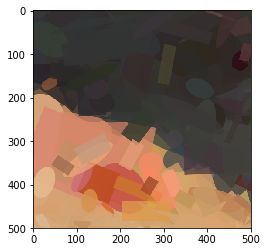

In [8]:
decoder.decode(encoded, size=500, from_bytes=True)

### COMPRESSION RATIO
$$0,06818 \cdot \frac{size^2}{actions}$$

Stała 0,06818 wynika z założenia reprezentacji obrazka wejściowego przez **3 B/pixel** (RGB) oraz obrazka skompresowanego przez **44 B/action** (4 bajty na numer akcji, 10 razy 4 bajty na argumenty akcji)

Przykładowo dla obrazka 100x100 i 100 akcji **compression ratio = 6,818**     

Skoro compression ratio zależy od ilości wykonanych akcji, istnieje maksymalna wartość, którą możemy użyć, aby skompresowany obrazek był mniejszy od obrazka wejściowego.   
$$maxActions=ceil(0.06818 \cdot size^2-1)$$
Przykładowo:   
obrazek 50x50 = max 170 akcji   
obrazek 100x100 = max 681 akcji        
obrazek 300x300 = max 6136 akcji

Liczbę możliwych do wykonania akcji można nieco zwiększyć poprzez zastosowanie dodatkowej kompresji na wynikowym ciągu wektorów akcji. Użyłam do tego celu gotowego kodera entropijnego wykorzystującego kodowanie arytmetyczne. Ma ono jednak sens jedynie po przekroczeniu pewnej liczby akcji, ponieważ w skompresowanym pliku przechowywana jest między innymi tablica prawdopodobieństw. Dla małych plików (mniej niż 200 akcji, ~ 8kB) kompresja spowoduje więc powstanie większego pliku niż plik wejściowy.
### COMPRESSION SPEED
Czas kompresji rośnie nieliniowo (o wiele szybciej) względem ilości akcji. Nie jestem w stanie wyprowadzić na to wzoru. Dłuższy czas dla "późniejszych" akcji spowodowany jest tym, że im bardziej obrazek przypomina obrazek źródłowy, tym trudniej (a co za tym idzie wolniej) znaleźć jest akcję która go jeszcze bardziej poprawi.    
TODO: Zrób ze dwa obrazki z fajną dokładnością tak żeby już były skompresowane, bo pokazywanie jak się one kompresują zajęłoby za dużo czasu


### DECOMPRESSION SPEED
TODO
(Zrób kilka testów dla 1,2,3,4... akcji. Zapisz czasy i postaraj się wywnioskować ile zajmuje cxzas otwarcia pluginu itd a ile to jest faktyczna zmiana związana z większą ilością akcji. Wzór powienien mieć stałą związaną z tym co jest zawsze wykonywane.  




100x100 - 681 : 924s/10s   
100x100 - 686 : 686s/10s   
100x100 - 10 : 8s/2s   
100x100 - 200 : 131s/4s   
     
11: 484 - 1376   
100: 4400 - 4582   
200: 8800 - 8120   

### Dekompresja do dowolnego rozmiaru

In [ ]:
import tqdm

encoding_times = []
decoding_times = []

for i in tqdm.tqdm(range(100))
    img_path = random_img()
    encoded, encoded_time = encoder.encode(img_path, actions=i, size=100, render=False, to_bytes=True)
    encoding_times.apeend(encoded_time)
    decoded_time = decoder.decode(encoded, size=500, from_bytes=True)
    decoding_times.append(decoded_time)
    
plt.plot(encoding_times)
plt.xlabel('action')
plt.ylabel('time [s]')
title = 'encoding 100x100 img'
plt.suptitle("\n".join(wrap(title, 60)))
plt.savefig('../result/coding/encoding_time.png')
plt.clf()

plt.plot(decoding_times)
plt.xlabel('action')
plt.ylabel('time [s]')
title = 'decoding 100x100 img'
plt.suptitle("\n".join(wrap(title, 60)))
plt.savefig('../result/coding/decoding_time.png')
plt.clf()

# Sieci konwolucyjne

In [11]:
from src.coding.coding import CnnEncoder, CnnDecoder
import numpy as np
    
def load_data(name):
    path = "../data/dataset/shape_small/"
    X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
    Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")
    return X, Y

def show_source(i):
    plt.imshow(np.ones(X[i].shape) + X[i])

In [12]:
encoder = CnnEncoder()
decoder = CnnDecoder()

In [13]:
X, _ = load_data('test')

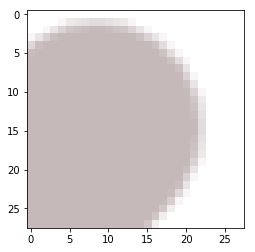

In [14]:
index = np.random.randint(0, X.shape[0])
show_source(index)

In [15]:
encoded = encoder.encode(X[index])
print(encoded)

compressed in 1.0605218410491943 sec
(2, array([0.49498618, 0.36093405, 0.35744056, 0.46738076, 0.2852464 ,
       0.599018  , 0.2694035 , 0.6574114 , 0.83537734], dtype=float32))


decompressed in 2.594597101211548 sec


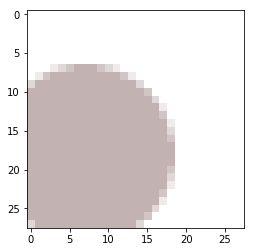

In [16]:
decoder.decode(encoded, size=28)

**obrazek wejściowy ~ 2352 bitów** (obrazek 28 x 28)   
**obrazek zakodowany ~ 44 bitów** (4 bity z numerem akcji + 40 bitów wektora argumentów)   
**compression ratio ~ 53,45** (dla jednej akcji) - czyli dla obrazka 28 x 28 ma to sens dla maksymalnie 53 akcji (można poprawić dodatkowo kompresując ciąg wektorów). Im większy obrazek, tym więcej akcji można wykonać, jednak ilość potrzebnych akcji do osiągnięcia podobnej precyzji jest proporcjonalna do wielkości.   
**compression speed ~ 2500 b/s** - przetwarzanie przez sieć neuronową (należy wziąć pod uwagę jednorazowy czas potrzebny na nauczenie sieci)
**decompression speed ~ 1000 b/s** - przetwarzanie w gimpie + zapis obrazka na dysk + ponowne wczytanie obrazka   
**dekompresja do dowolnego rozmiaru**   